In [1]:
# Import the packages we will use
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [2]:
import sys
import os
sys.path.insert(0, os.getcwd().rsplit('/',1)[0])

import loops_utils

In [3]:
# The following directive activates inline plotting
%matplotlib inline

### Bins visualization

In [4]:
# 1 or 5 or 6 to assign chr
chr_num = 1
chr = 'chr' + str(chr_num)

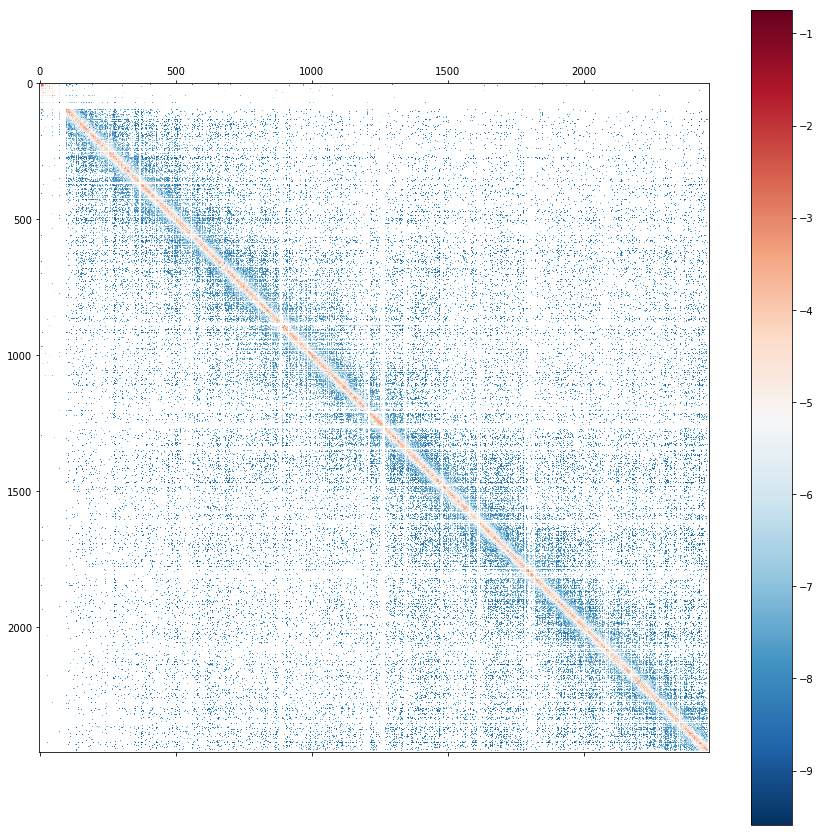

In [5]:
arr = np.load('arrs/2kb_chr'+str(chr_num)+'_log.npy')
loops_utils.plot_HiC(arr, name = 'dicty_hic_raw')

Normalized map was produced by function:
It divides each diagonal of a Hi-C contact map by its' mean.  
It also does it in a smart way: it calculates averages over stripes from X to X*1.05, and divides each stripe by its mean.  
It allows to avoid divergence far from the main diagonal with a very few reads.  
(comment from __mirnylib__)

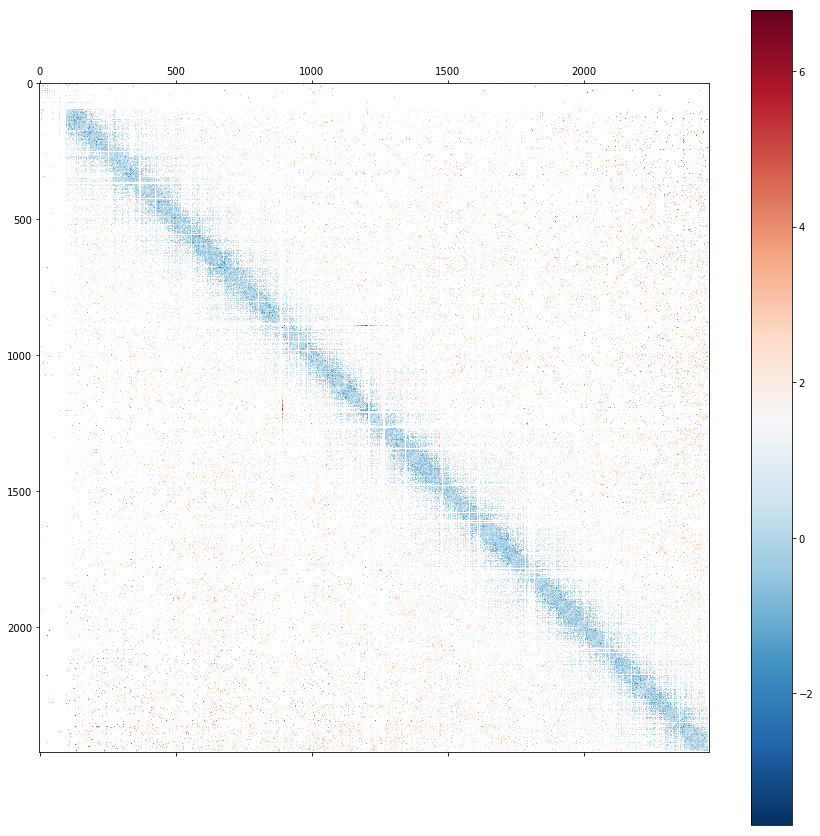

In [6]:
arr_norm_log = np.load('arrs/2kb_chr'+str(chr_num)+'_norm_log.npy')
loops_utils.plot_HiC(arr_norm_log, name='dicty_hic_norm')

### Read loops info

In [7]:
loops_info = pandas.read_excel('dicty_loop_positions_Chr1_Chr5_Chr6.xlsx')
loops_positions = loops_info[loops_info.Chr == chr_num]

### Visualize loops on plots

In [8]:
loops_x = loops_positions['Genomic bin, Left base'].values
loops_y = loops_positions['Genomic bin, Right base'].values
loops_type = loops_positions['"Extrusion track"'].values
loops_size = loops_positions['Size (Kb)'].values

In [9]:
edgecolors = []
for l in loops_type:
    if l == 0:
        edgecolors.append('blue')
    elif l == 1:
        edgecolors.append('lime')
    else:
        edgecolors.append('cyan')

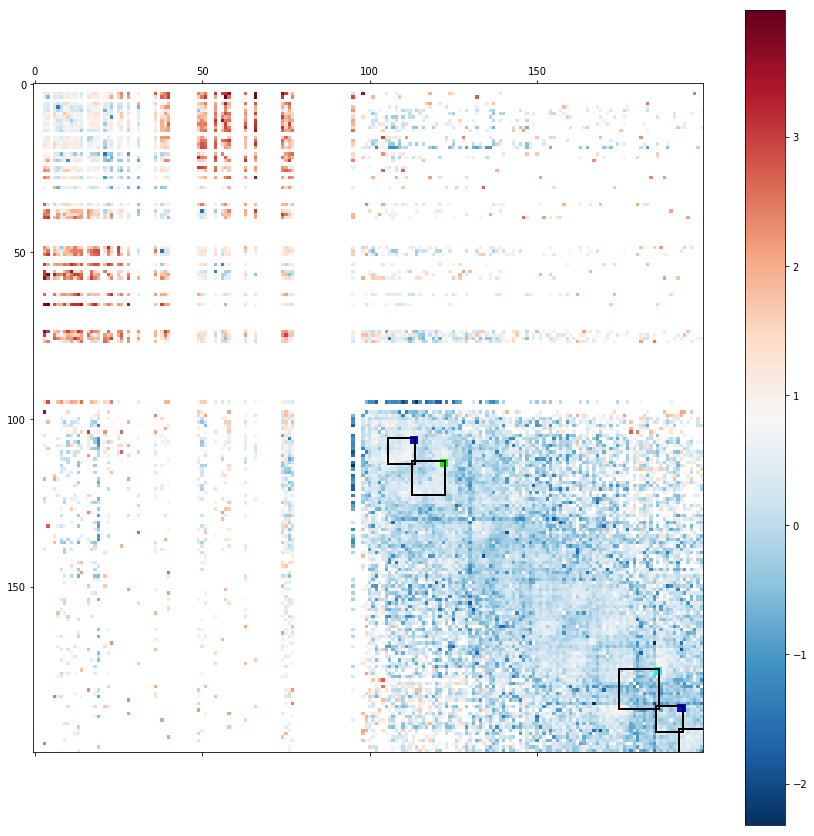

In [10]:
start_bin = 0
end_bin = start_bin + 200

ax = loops_utils.plot_HiC(arr_norm_log[start_bin:end_bin, start_bin:end_bin])

for idx, x in enumerate(loops_x):
    loop = matplotlib.patches.Rectangle((loops_y[idx]-1.5-start_bin, x-1.5-start_bin), 1, 1,
                                        fill=None, alpha=1, edgecolor=edgecolors[idx], linewidth=5.0)
    ax.add_patch(loop)
    
    #loop = matplotlib.patches.Rectangle((x-1.5-start_bin, loops_y[idx]-1.5-start_bin), 1, 1,
    #                                    fill=None, alpha=1, edgecolor=edgecolors[idx], linewidth=5.0)
    #ax.add_patch(loop)
    
    loop_tr = matplotlib.patches.Rectangle((loops_y[idx]-0.5-loops_size[idx]/2-start_bin, x-1.5-start_bin),
                                           loops_size[idx]/2, loops_size[idx]/2, fill=None, alpha=1, edgecolor='black',
                                          linewidth=2.0)
    ax.add_patch(loop_tr)
    
plt.savefig('pictures/dicty_loops_viz.png')

### Average loop

In [11]:
def avg_loops(arr):
    '''
        Get average of all loops by extracting each loop and summing them into one. 
        After that divide by loops number
    '''
    loop_y_centroid = loops_y[1]-1
    loop_x_centroid = loops_x[1]-1
    loop_sum = loops_utils.get_loop_with_window(arr, loop_y_centroid, loop_x_centroid)

    for idx in range(2, loops_x.shape[0]):
        loop_y_centroid = loops_y[idx]-1
        loop_x_centroid = loops_x[idx]-1
        loop_window = loops_utils.get_loop_with_window(arr, loop_y_centroid, loop_x_centroid)
        loop_sum = loop_sum + np.nan_to_num(loop_window)
        
    loop_avg = loop_sum / loops_x.shape[0]    
        
    return loop_avg

In [12]:
loop_y_centroid = loops_y[0]-1
loop_x_centroid = loops_x[0]-1
loop_sum = loops_utils.get_loop_with_window(arr, loop_y_centroid, loop_x_centroid)
loop_sum.shape

(13, 13)

### Normalized Hi-C

In [13]:
arr = np.load('arrs/2kb_chr'+str(chr_num)+'_norm.npy')

###### Single loop

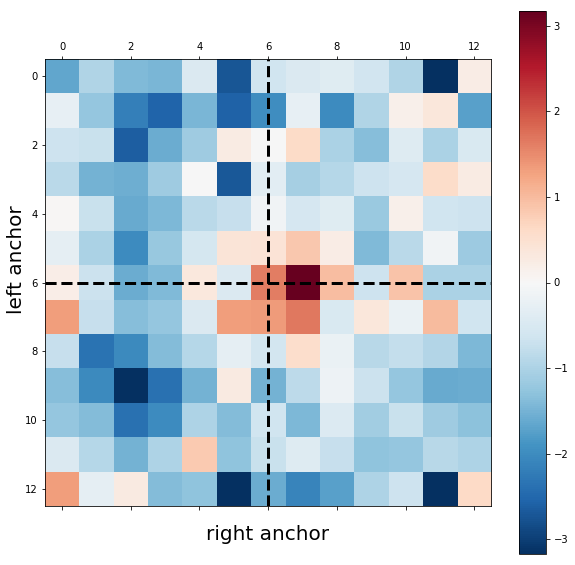

In [14]:
idx = 17
loop_y_centroid = loops_y[idx]-1
loop_x_centroid = loops_x[idx]-1
loop_window = loops_utils.get_loop_with_window(arr, loop_y_centroid, loop_x_centroid)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_window), figsize=(10,10),
                     name='dicty_norm_single_loop', is_loop=True)

single loop with log

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/anaconda3/envs/loops/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:141: RuntimeWarning: invalid value encountered in subtract
  z_normed_arr = (arr - mean)/std


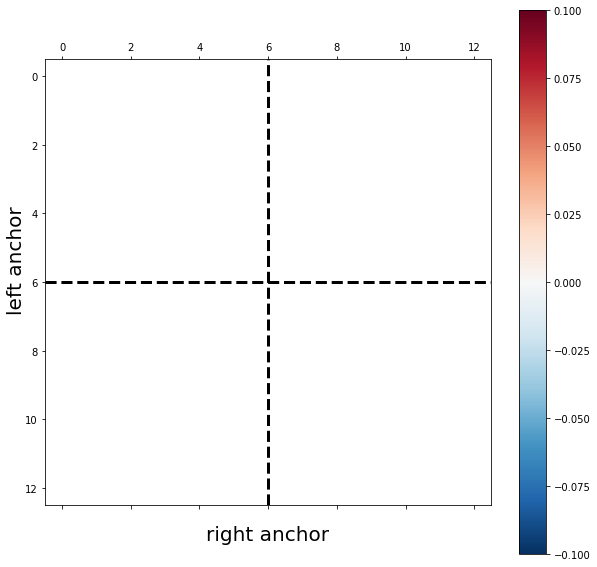

In [15]:
idx = 20
loop_y_centroid = loops_y[idx]-1
loop_x_centroid = loops_x[idx]-1
loop_window = loops_utils.get_loop_with_window(arr, loop_y_centroid, loop_x_centroid)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(np.log(loop_window)), figsize=(10,10),
                     name='dicty_norm_log_single_loop', is_loop=True)

###### Average loop

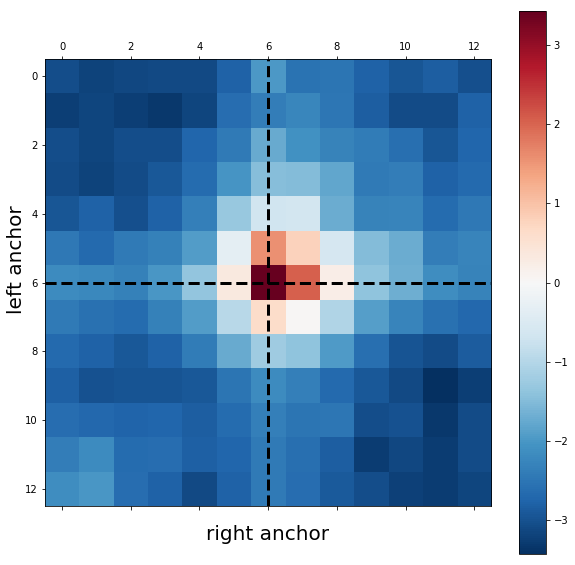

In [16]:
loop_avg = avg_loops(arr)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_avg), figsize=(10, 10),
                     name='dicty_norm_average_loop', is_loop=True)

### Raw Hi-C

In [17]:
arr = np.load('arrs/2kb_chr'+str(chr_num)+'.npy')

###### Single loop

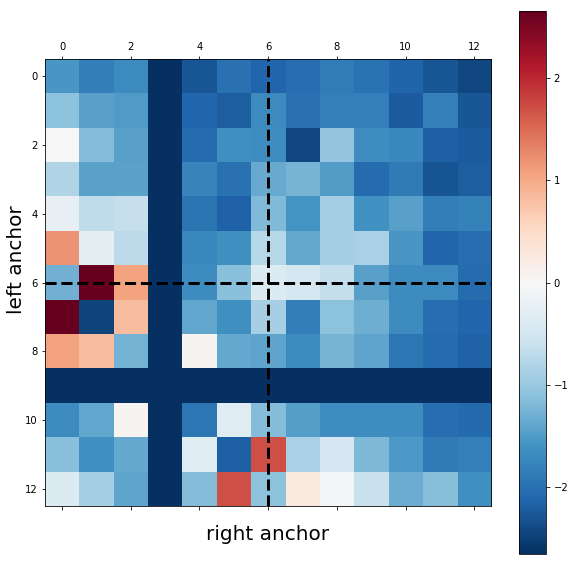

In [18]:
idx = 20
loop_y_centroid = loops_y[idx]-1
loop_x_centroid = loops_x[idx]-1
loop_window = loops_utils.get_loop_with_window(arr, loop_y_centroid, loop_x_centroid)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_window), figsize=(10,10),
                     name='dicty_raw_single_loop', is_loop=True)

###### Average loop

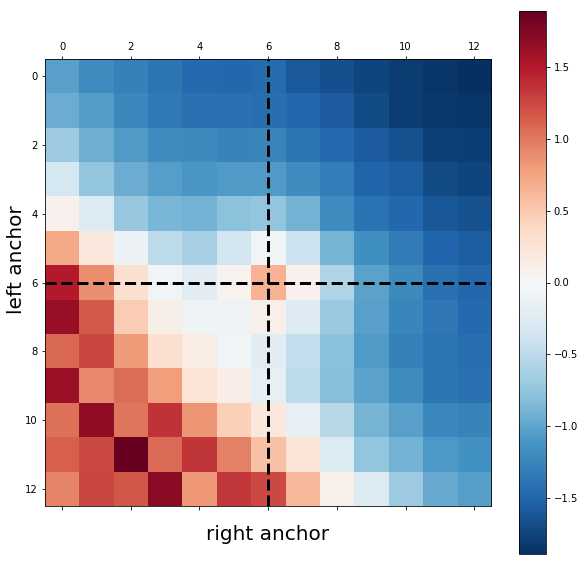

In [19]:
loop_avg = avg_loops(arr)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(loop_avg), figsize=(10, 10),
                     name='dicty_raw_average_loop', is_loop=True)